In [242]:
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [243]:
from pathlib import Path

import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px 
import plotly.graph_objects as go 
from plotly.subplots import  make_subplots
from plotly.colors import make_colorscale
import pandas as pd
import scipy.stats as sst
import cv2 as cv
from tqdm import tqdm


import networkx as nx
import random

from vame.util.auxiliary import read_config
from vame.analysis.community_analysis import get_labels
from vame.analysis.tree_hierarchy import merge_func
from vame.analysis.community_analysis import graph_to_tree
from vame.analysis.videowriter import get_cluster_vid

import my_paths as mp

from src.loaders import get_transition_matrices

In [244]:
cfg = read_config(mp.vame_path / "config.yaml")


In [245]:
data_names = np.sort(np.asarray(cfg["video_sets"])) 
print(data_names)

all_labels = get_labels(
    cfg=cfg,
    files=data_names,
    model_name=cfg['model_name'], 
    n_cluster=cfg['n_cluster'],
    parameterization=cfg["parameterization"]
)


['2024-02-19T12:28:56_1' '2024-02-19T12:29:49_1' '2024-02-19T12:30:29_1'
 '2024-02-19T12:31:46_1' '2024-02-19T12:32:16_1' '2024-02-19T12:32:46_1'
 '2024-02-19T12:38:33_1' '2024-02-19T12:40:17_1' '2024-02-19T12:41:22_1'
 '2024-02-19T12:45:00_1' '2024-02-19T12:45:51_1' '2024-02-19T12:47:10_1'
 '2024-02-19T12:49:42_1' '2024-02-19T12:50:26_1' '2024-02-19T12:52:24_1'
 '2024-02-19T12:54:46_1' '2024-02-19T12:54:46_2' '2024-02-19T12:58:34_1'
 '2024-02-19T12:59:09_1' '2024-02-19T12:59:09_2' '2024-02-19T12:59:09_3'
 '2024-02-19T12:59:43_1' '2024-02-19T12:59:43_2' '2024-02-19T13:02:57_1'
 '2024-02-19T13:03:49_1' '2024-02-19T13:04:26_1' '2024-02-19T13:08:00_1'
 '2024-02-19T13:08:00_2' '2024-02-19T13:09:01_1' '2024-02-21T13:47:10_1'
 '2024-02-21T13:47:54_1' '2024-02-21T13:48:22_1' '2024-02-21T13:49:01_1'
 '2024-02-21T13:59:33_1' '2024-02-21T14:00:56_1' '2024-02-21T14:02:05_1'
 '2024-02-21T14:02:21_1' '2024-02-21T14:02:33_1' '2024-02-21T14:03:04_1'
 '2024-02-21T14:03:13_1' '2024-02-21T14:03:39_1' '2

In [246]:
print([len(lab) for lab in all_labels])

[1546, 1062, 330, 1251, 2007, 316, 643, 852, 1706, 1275, 1505, 1298, 1005, 1032, 1447, 840, 1017, 926, 880, 983, 289, 303, 912, 783, 949, 1419, 943, 804, 323, 437, 1137, 841, 292, 362, 923, 873, 242, 790, 275, 1164, 966, 251, 363, 1154, 1644, 431, 196, 435, 1536, 365, 310, 346, 1595, 1647, 351, 1358, 898, 711, 407, 563, 1145, 1026, 544, 761, 508, 387, 346, 313, 924, 1112, 307, 356, 483, 1132, 804, 1347, 1497, 1203, 992, 592, 807, 1459, 545, 971, 355, 1404, 805, 775, 913, 268, 1567, 842, 704, 1119, 496, 898, 518, 401, 1605, 1084]


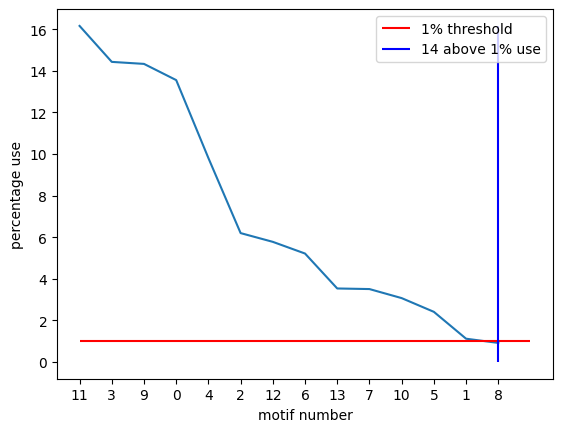

In [247]:
# histogram of most used motifs across all data


merged_labels = np.concatenate(all_labels)
lbl, count = np.unique(merged_labels, return_counts=True)

frac_use = count / count.sum()
sorter = np.argsort(frac_use)[::-1]

first_under_1 = np.argwhere(frac_use[sorter]< 0.01)[0,0]


_ = plt.plot(frac_use[sorter] * 100)
_ = plt.xticks(ticks=np.arange(len(lbl)), labels=lbl[sorter])
_ = plt.hlines(xmin=0, xmax=len(lbl),y=1, color="red", label="1% threshold")
_ = plt.vlines(x=first_under_1, ymin=0, ymax=np.max(frac_use*100), color="blue", label=f"{first_under_1+1} above 1% use")
_ = plt.legend()
_ = plt.xlabel("motif number")
_ = plt.ylabel("percentage use")


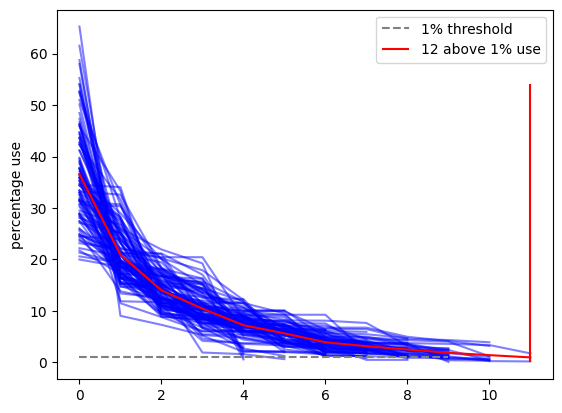

In [248]:
# histogram of most used motifs across all data
hists = list()
for lab in all_labels:
    lbl, count = np.unique(lab, return_counts=True)
    
    frac_use = count / count.sum()
    sorter = np.argsort(frac_use)[::-1]
    y = frac_use[sorter] * 100
    _ = plt.plot(y, color='blue', alpha=0.5)
    hists.append(y)
    
mean = np.full([len(hists), np.max([len(h) for h in hists])], np.nan)

for hh, hst in enumerate(hists):
    mean[hh,:len(hst)] = hst

y_mean = np.nanmean(mean, axis=0)
y_mean[np.isnan(y_mean)] = 0 

_ = plt.plot(y_mean, color='red')

first_under_1 = np.argwhere(y_mean < 1)[0,0]
# _ = plt.xticks(ticks=np.arange(len(lbl)), labels=lbl[sorter])
_ = plt.hlines(xmin=0, xmax=len(lbl),y=1, color="gray",linestyle='dashed', label="1% threshold")
_ = plt.vlines(x=first_under_1, ymin=0, ymax=np.max(frac_use*100), color="red", label=f"{first_under_1+1} above 1% use")
_ = plt.legend()
# _ = plt.xlabel("motif number")
_ = plt.ylabel("percentage use")

In [249]:
# values found by looking at the videos
# todo automatize the flower type detection
right_start = '2024-02-19T12:38:33_1'
right_end = '2024-02-21T13:47:10_1' # not inclusive

direction = np.full_like(data_names, fill_value='zig_02_left')
direction[
np.argwhere(data_names == right_start)[0,0]:
np.argwhere(data_names == right_end)[0,0]
] = 'zig_02_right'

side_df = pd.DataFrame(
    data = [data_names, direction] , index= ['datum', 'flower_type']
).T

side_df

,datum,flower_type
0,2024-02-19T12:28:56_1,zig_02_left
1,2024-02-19T12:29:49_1,zig_02_left
2,2024-02-19T12:30:29_1,zig_02_left
3,2024-02-19T12:31:46_1,zig_02_left
4,2024-02-19T12:32:16_1,zig_02_left
...,...,...
95,2024-02-21T14:53:46_1,zig_02_left
96,2024-02-21T14:53:57_1,zig_02_left
97,2024-02-21T14:54:33_1,zig_02_left
98,2024-02-21T14:54:45_1,zig_02_left


In [250]:
from src.utils import get_transition_matrix
def get_common_transition_matrix(data_names):
    cfg = read_config(mp.vame_path / "config.yaml")
    labels = get_labels(
        cfg=cfg, 
        files=data_names,
        model_name = cfg['model_name'],
        n_cluster=cfg['n_cluster'],
        parameterization = cfg['parameterization'] 
    )
    # this is a little hack that adds some false transitions
    # but they are very few and its probably fine for now
    
    trans_mat = get_transition_matrix(
        labels, 
        states=[str(ct)for ct in range(cfg['n_cluster'])], 
        keep_diagonal=False
    )
    
    all_labels = np.concatenate(labels) 

    
    # _, trans_mat, _ = get_adjacency_matrix(
    #     all_labels, cfg['n_cluster']
    # )
    
    lab, count = np.unique(all_labels, return_counts=True)
    motif_use = np.zeros(cfg['n_cluster'])
    motif_use[lab] = count
    motif_use = motif_use / motif_use.sum() # normalization
    
    return trans_mat, motif_use


In [251]:
# try sorting the matrix using the same logic than the binary tree clustering
# merge_func(left_trans_mat, left_trans_mat.shape[0], left_motif, merge_sel=1)

def sort_matrix(trans_mat, motif_use):
    n_present_motifs = np.sum(motif_use > 0)
    
    trans_redux = trans_mat.values.copy()
    motif_redux = motif_use.copy()
    
    node_order = list()
    tree = dict()
    
    for i in range(n_present_motifs - 1):

        nodes = merge_func(trans_redux, trans_redux.shape[0], motif_redux, 1)
        nodes = np.asarray(nodes).squeeze()
        
        # print(f"\n{nodes}")
        node_order.append(nodes)

        # asigns the sum of columns and rows to the second colum and row respectively, and zeroes the first
        trans_redux[nodes[1], :] = trans_redux[nodes, :].sum(axis=0)
        trans_redux[:, nodes[1]] = trans_redux[:, nodes].sum(axis=1)

        trans_redux[nodes[0], :] = 0
        trans_redux[:, nodes[0]] = 0

        # self transition set to zero
        trans_redux[nodes[1], nodes[1]] = 0
        
        # sums the fraction of appearance of the two merged motifs into one. and zeroes the other
        motif_redux[nodes[1]] = motif_redux[nodes].sum()
        motif_redux[nodes[0]] = 0
        
        # mini_mat = trans_redux[trans_redux.sum(axis=1)>0,:][:, trans_redux.sum(axis=1)>0,]
        # _ = plt.imshow(mini_mat)
        # _ = plt.show()
        
        # constuct a "tree" by asigning the apropiate motif idx 
        # the the current merge node 
        traversed =np.isin(nodes, list(tree.keys()))
        
        if not traversed[0] and traversed[1]:
            # merges leaf to fork and assigns to the fork key
            tree[nodes[1]] = np.concatenate(
                [nodes[0][None], tree[nodes[1]]]
            )
        elif traversed[0] and not traversed[1]:
            # merges leaf to fork and assigns to the leaf key
            tree[nodes[1]] = np.concatenate(
                [tree[nodes[0]], nodes[1][None]]
            )
            # removes merged fork
            tree.pop(nodes[0])
            # raise ValueError('this should never happen')
        elif traversed[0] and traversed[1]:
            # merging two forks and assigning to the second fork key
            tree[nodes[1]] = np.concatenate(
                [tree[nodes[0]], tree[nodes[1]]]
            )
            # removes the merged fork key
            tree.pop(nodes[0])
        elif not traversed[0] and not traversed[1]:
            # merging two leaves and asigning fork to the second leaf key
            tree[nodes[1]] = nodes
            
        # print(tree)
        
    sort_order = tree[list(tree.keys())[0]]
        
    return node_order, sort_order

In [252]:
full_trans_mat, full_motif = get_common_transition_matrix(side_df.datum.values)
left_trans_mat, left_motif = get_common_transition_matrix(side_df.query("flower_type == 'zig_02_left'").datum.values)
right_trans_mat, right_motif = get_common_transition_matrix(side_df.query("flower_type == 'zig_02_right'").datum.values)

/home/mateo/code/beehaviour/src/utils.py:57: UserWarning:

there are {'8'} in set states not in observed states



In [253]:
nodes, sorter  = sort_matrix(full_trans_mat, full_motif)

/home/mateo/code/VAME/vame/analysis/tree_hierarchy.py:84: RuntimeWarning:

divide by zero encountered in double_scalars

/home/mateo/code/VAME/vame/analysis/tree_hierarchy.py:84: RuntimeWarning:

invalid value encountered in double_scalars



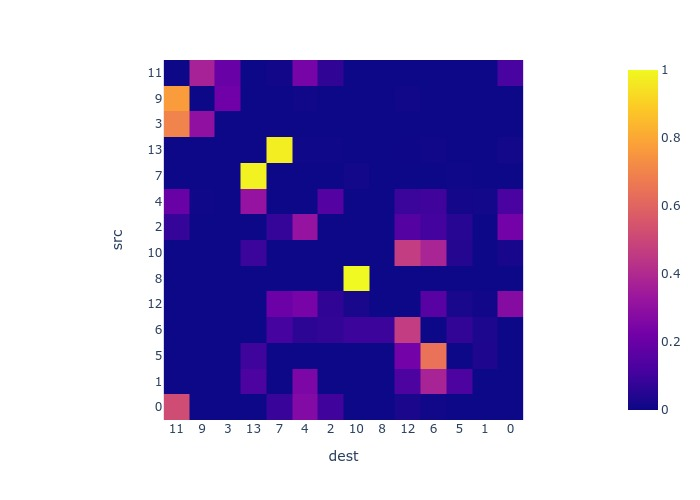

In [254]:
fig = px.imshow(full_trans_mat[sorter,:][:,sorter], 
                aspect='equal')
fig.show(renderer='jpeg')
# fig.show()

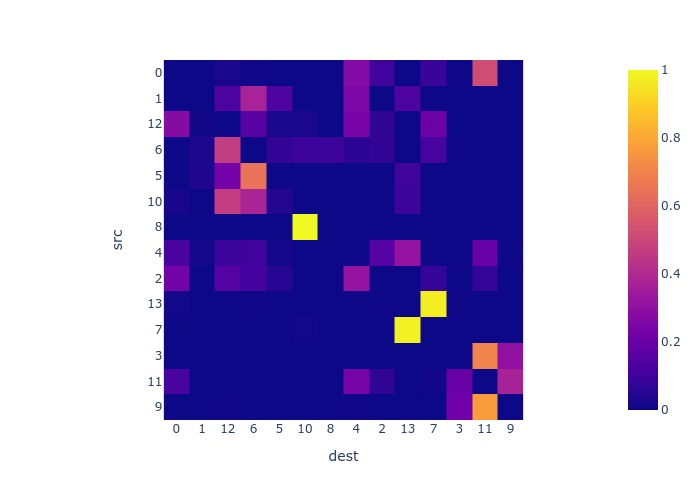

In [255]:
# manual sorter from looking at the dicotomic tree
manual_sorter = np.asarray([6,5,12,10,8,1,4,2,13,7,0,11,9,3])[::-1]

tree_sorter = [0,1,12,6,5,10,8,4,2,13,7,3,11,9]
manual_sorter = tree_sorter
# manual_sorter = sorter
fig = px.imshow(full_trans_mat[manual_sorter,:][:,manual_sorter], 
                aspect='equal')
fig.show(renderer='jpeg')

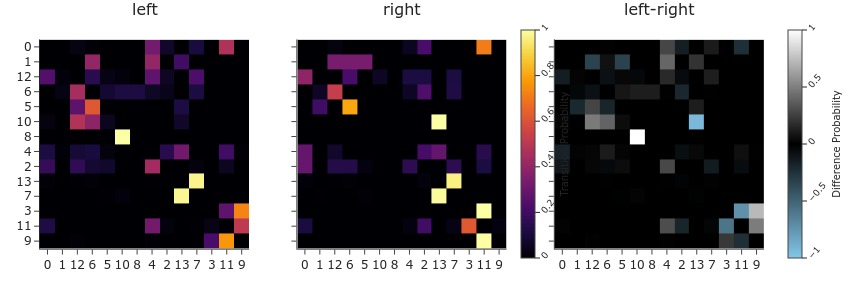

In [256]:
fig = make_subplots(
    1, 3, shared_xaxes='all', shared_yaxes='all',
    subplot_titles=['left', 'right', 'left-right']
)

matrices = [left_trans_mat, right_trans_mat, left_trans_mat - right_trans_mat]

for ii, mat in enumerate(matrices):
    pan = px.imshow(
        mat[manual_sorter, :][:, manual_sorter],
        aspect='equal',
        # coloraxis='coloraxis',
        # name=ii
    )['data']
    fig.add_traces(pan, cols=[ii + 1] * len(pan), rows=[1] * len(pan))

fig.update_traces(
    selector=dict(xaxis='x3'),
    coloraxis='coloraxis2',
    reversescale=False
)

LEFT_COLOR = "#ffffff"
RIGHT_COLOR = "#83c7ea"
# left_right_scale = make_colorscale([LEFT_COLOR, '#000000',RIGHT_COLOR])
left_right_scale = make_colorscale([RIGHT_COLOR, '#000000', LEFT_COLOR])

fig.update_layout(
    width=96 * 9, height=96 * 3,
    template="simple_white",
    margin=dict(l=40, r=10, t=20, b=20),

    xaxis2=dict(
        tickmode='array',
        tickvals=list(range(len(tree_sorter))),
        ticktext=tree_sorter
    ),

    yaxis=dict(scaleanchor='x'),
    yaxis2=dict(scaleanchor='x2',
                tickmode='array',
                tickvals=list(range(len(tree_sorter)))
                ),
    yaxis3=dict(scaleanchor='x3',
                tickmode='array',
                tickvals=list(range(len(tree_sorter)))
                ),

    # 0 to 1 coloraxis
    coloraxis=dict(
        showscale=True,
        colorscale="inferno",
        cmid=None,
        colorbar=dict(
            x=0.65,
            orientation='v',
            thicknessmode='fraction',
            thickness=0.02,
            lenmode='fraction', len=1,
            tickangle=-50,
            tickfont_size=9,
            title=dict(
                text='Transition Probability',
                side='right',
                font_size=10
            )
        )
    ),
    # difference coloraxis
    coloraxis2=dict(
        showscale=True,
        colorscale=left_right_scale,
        cmid=0,
        colorbar=dict(
            orientation='v',
            thicknessmode='fraction',
            thickness=0.02,
            lenmode='fraction', len=1,
            tickangle=-50,
            tickfont_size=9,
            title=dict(
                text='Difference Probability',
                side='right',
                font_size=10
            )
        )
    )
)
fig.update_xaxes(constrain='domain', )
fig.update_yaxes(autorange='reversed', constrain='domain', scaleratio=1)

fig.show(renderer='jpeg')
fig.write_image(mp.fig_path / "transition_matrices.svg")

# point plots 
might be more meaningfull than the matrix transition differences. Furthermore it might let me see the variation in
stragegies between individuals/instances for the left and right beds

In [257]:
motif_fraction = np.zeros([side_df.shape[0], cfg['n_cluster']])
for dd, datum_name in enumerate(side_df.datum.values):   
    motif_series = get_labels(
    cfg=cfg,
    files=[datum_name],
    model_name=cfg['model_name'], 
    n_cluster=cfg['n_cluster'],
    parameterization=cfg["parameterization"]
    )[0]
    mtf, cnt = np.unique(motif_series, return_counts=True)
    motif_fraction[dd,mtf] = cnt / np.sum(cnt)
    
motif_df = pd.DataFrame(data=motif_fraction, columns=list(range(cfg["n_cluster"])))

toplot = pd.concat([side_df, motif_df], axis=1)
toplot = toplot.melt(id_vars=["datum", "flower_type"], value_vars=list(range(cfg["n_cluster"])), var_name='motif_number', value_name="motif_fraction")
toplot['motif_percent'] = toplot['motif_fraction']*100


# Empirically defined
community_bags = {
    'Advancing': [0],
    'Rearing': [1],
    'Rolling': [12, 5, 6],  # a little bit of reaching and squeezing too
    'Squeezing': [10, 8],  # rightwards, have not seen left turn squeeze
    'Retreating': [4, 2, 13, 7],
    'Libating': [3, 11, 9],

}

mot2com = dict()
for com, mots in community_bags.items():
    for m in mots:
        mot2com[m] = com

toplot['community_name'] = toplot['motif_number'].replace(mot2com)
toplot["motif_number"] = toplot['motif_number'].astype(str)


Advancing
motif 0 pvalue: 13.359898414071052  NS
Rearing
motif 1 pvalue: 12.738580393640312  NS
Rolling
motif 5 pvalue: 2.2970360689353617  NS
motif 6 pvalue: 0.022738730207073968  *
motif 12 pvalue: 0.04293384141565006  *
Squeezing
motif 8 pvalue: 1.2493872382816846  NS
motif 10 pvalue: 5.128365165306417e-05  ***
Retreating
motif 2 pvalue: 7.064714112027288e-10  ***
motif 4 pvalue: 1.0919976512788527e-09  ***
motif 7 pvalue: 0.0017270191540245418  **
motif 13 pvalue: 0.0016145979263466892  **
Libating
motif 3 pvalue: 9.047096033118931e-09  ***
motif 9 pvalue: 0.0005365266468782392  ***
motif 11 pvalue: 0.006581358222086506  **


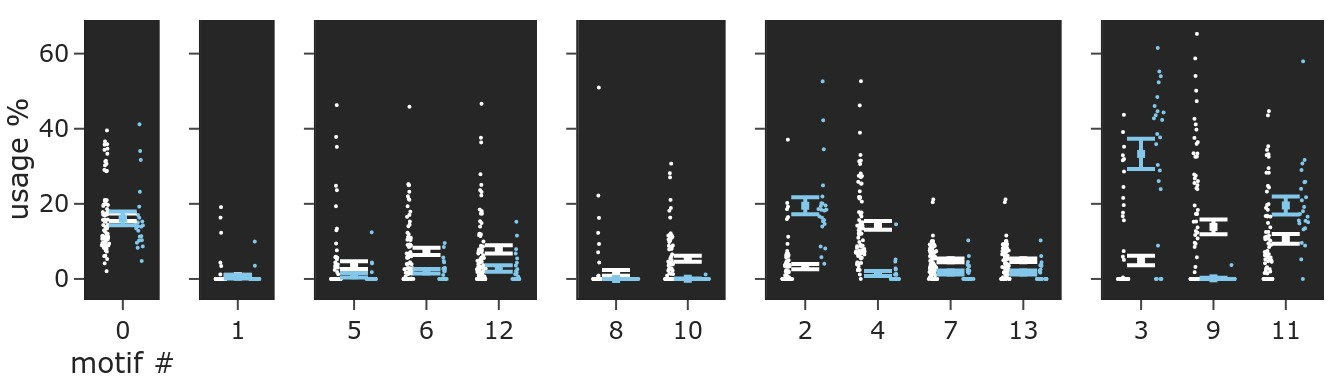

In [258]:
ord_community_names = ["Advancing", "Rearing", "Rolling", "Squeezing",
                       "Retreating", "Libating"]
# ord_community_names = ["Rolling"]

LEFT_COLOR = "#ffffff"
RIGHT_COLOR = "#83c7ea"

fig = make_subplots(1, len(ord_community_names), shared_yaxes="all",
                    shared_xaxes=False,
                    column_width=[len(community_bags[key])/14 for key in ord_community_names])
for col, community_name in enumerate(ord_community_names):
    print(community_name)
    mini_df = toplot.query(f"community_name == '{community_name}'").copy()
    mini_df['motif_number'] = mini_df['motif_number'].astype(str)

    # strip plots for all motifs
    panel_fig = px.strip(mini_df, x='motif_number', y='motif_percent',
                         color='flower_type',
                         color_discrete_map=dict(zig_02_left=LEFT_COLOR,
                                                 zig_02_right=RIGHT_COLOR))

    motifs_in_community = mini_df.motif_number.unique()

    for motif_number in motifs_in_community:
        x = [motif_number]
        vect = list()
        for flower_type, color in zip(['zig_02_left', 'zig_02_right'],
                                      [LEFT_COLOR, RIGHT_COLOR]):
            y = mini_df.query(
                f"motif_number == '{motif_number}' "
                f"and flower_type == '{flower_type}'"
            ).motif_percent.values
            vect.append(y)

            ym = [np.mean(y)]
            ye = [sst.sem(y)]
            # ye = [np.std(y)]

            panel_fig.add_trace(
                go.Scatter(x=x, y=ym,
                           mode='markers',
                           marker=dict(color=color, symbol='square', size=4, line_color='black'),
                           error_y=dict(array=ye, color=color,
                                        thickness=2, width=7),
                           showlegend=False)
            )

        # stat test with bonferroni correction
        # pval = sst.mannwhitneyu(*vect).pvalue  * len(motifs_in_community)
        pval = sst.mannwhitneyu(*vect).pvalue  * cfg['n_cluster']
        
        if pval <= 0.001:
            sig_symbol = '***'
        elif pval <= 0.01:
            sig_symbol = '**'
        elif pval <= 0.05:
            sig_symbol = '*'
        elif pval > 0.05:
            sig_symbol = 'NS'
            
        print(f"motif {motif_number} pvalue: {pval}  {sig_symbol}")

    # panel_fig.show(renderer='jpeg')

    pan = panel_fig['data']

    fig.add_traces(pan, rows=[1] * len(pan), cols=[col + 1] * len(pan), )


fig.update_traces(
    selector=dict(type='box'),
    marker_size=2,
)

fig.update_traces(
    selector=dict(type='box', name="zig_02_left"),
    pointpos=-1,
)

fig.update_traces(
    selector=dict(type='box', name="zig_02_right"),
    pointpos=1,
)

fig.update_layout(
    template="simple_white",
    width=96 * 7, height=96 * 2,
    margin=dict(l=40, r=10, t=10, b=20),
    xaxis=dict(title=dict(text='motif #')),
    yaxis=dict(title=dict(text='usage %')),
    showlegend=False,
    plot_bgcolor = "#262626",
    paper_bgcolor = "#ffffff",
    
)

fig.update_xaxes(title_standoff=0)
fig.update_yaxes(title_standoff=0)

fig.show(renderer='jpeg', scale=2)
# fig.write_image(mp.fig_path / "motif_percent_usage.svg")

# full tree

Pooling all data together, what are the transitions most common? how to group everything and turn it into a tree?

In [261]:
T = graph_to_tree(
    full_motif, full_trans_mat, 
    n_cluster=cfg['n_cluster'], 
    merge_sel=1) 

/home/mateo/miniconda3/envs/VAME/lib/python3.7/site-packages/xarray/core/computation.py:733: RuntimeWarning:

divide by zero encountered in true_divide

/home/mateo/miniconda3/envs/VAME/lib/python3.7/site-packages/xarray/core/computation.py:733: RuntimeWarning:

divide by zero encountered in true_divide

/home/mateo/miniconda3/envs/VAME/lib/python3.7/site-packages/xarray/core/computation.py:733: RuntimeWarning:

divide by zero encountered in true_divide

/home/mateo/miniconda3/envs/VAME/lib/python3.7/site-packages/xarray/core/computation.py:733: RuntimeWarning:

divide by zero encountered in true_divide

/home/mateo/miniconda3/envs/VAME/lib/python3.7/site-packages/xarray/core/computation.py:733: RuntimeWarning:

divide by zero encountered in true_divide

/home/mateo/miniconda3/envs/VAME/lib/python3.7/site-packages/xarray/core/computation.py:733: RuntimeWarning:

divide by zero encountered in true_divide

/home/mateo/miniconda3/envs/VAME/lib/python3.7/site-packages/xarray/core/computati

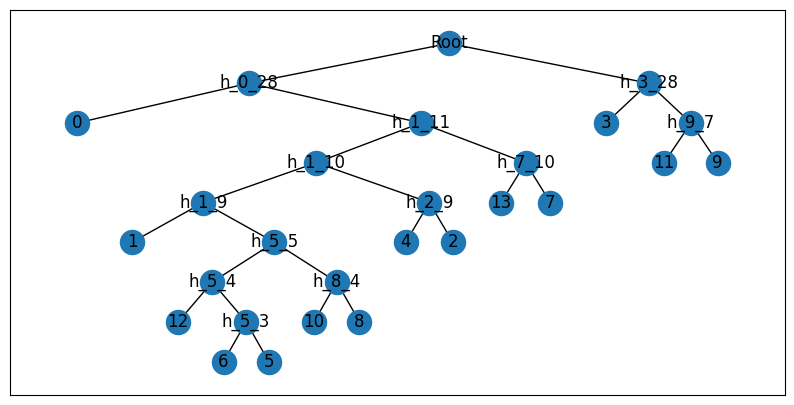

In [262]:
def hierarchy_pos(G, root=None, width=1., vert_gap = 0.2, vert_loc = 0, leaf_vs_root_factor = 0.5):

    '''
    If the graph is a tree this will return the positions to plot this in a 
    hierarchical layout.
    
    Based on Joel's answer at https://stackoverflow.com/a/29597209/2966723,
    but with some modifications.  

    We include this because it may be useful for plotting transmission trees,
    and there is currently no networkx equivalent (though it may be coming soon).
    
    There are two basic approaches we think of to allocate the horizontal 
    location of a node.  
    
    - Top down: we allocate horizontal space to a node.  Then its ``k`` 
      descendants split up that horizontal space equally.  This tends to result
      in overlapping nodes when some have many descendants.
    - Bottom up: we allocate horizontal space to each leaf node.  A node at a 
      higher level gets the entire space allocated to its descendant leaves.
      Based on this, leaf nodes at higher levels get the same space as leaf
      nodes very deep in the tree.  
      
    We use use both of these approaches simultaneously with ``leaf_vs_root_factor`` 
    determining how much of the horizontal space is based on the bottom up 
    or top down approaches.  ``0`` gives pure bottom up, while 1 gives pure top
    down.   
    
    
    :Arguments: 
    
    **G** the graph (must be a tree)

    **root** the root node of the tree 
    - if the tree is directed and this is not given, the root will be found and used
    - if the tree is directed and this is given, then the positions will be 
      just for the descendants of this node.
    - if the tree is undirected and not given, then a random choice will be used.

    **width** horizontal space allocated for this branch - avoids overlap with other branches

    **vert_gap** gap between levels of hierarchy

    **vert_loc** vertical location of root
    
    **leaf_vs_root_factor**

    xcenter: horizontal location of root
    '''
    if not nx.is_tree(G):
        raise TypeError('cannot use hierarchy_pos on a graph that is not a tree')

    if root is None:
        if isinstance(G, nx.DiGraph):
            root = next(iter(nx.topological_sort(G)))  #allows back compatibility with nx version 1.11
        else:
            root = random.choice(list(G.nodes))

    def _hierarchy_pos(G, root, leftmost, width, leafdx = 0.2, vert_gap = 0.2, vert_loc = 0, 
                    xcenter = 0.5, rootpos = None, 
                    leafpos = None, parent = None):
        '''
        see hierarchy_pos docstring for most arguments

        pos: a dict saying where all nodes go if they have been assigned
        parent: parent of this branch. - only affects it if non-directed

        '''

        if rootpos is None:
            rootpos = {root:(xcenter,vert_loc)}
        else:
            rootpos[root] = (xcenter, vert_loc)
        if leafpos is None:
            leafpos = {}
        children = list(G.neighbors(root))
        leaf_count = 0
        if not isinstance(G, nx.DiGraph) and parent is not None:
            children.remove(parent)  
        if len(children)!=0:
            rootdx = width/len(children)
            nextx = xcenter - width/2 - rootdx/2
            for child in children:
                nextx += rootdx
                rootpos, leafpos, newleaves = _hierarchy_pos(G,child, leftmost+leaf_count*leafdx, 
                                    width=rootdx, leafdx=leafdx,
                                    vert_gap = vert_gap, vert_loc = vert_loc-vert_gap, 
                                    xcenter=nextx, rootpos=rootpos, leafpos=leafpos, parent = root)
                leaf_count += newleaves

            leftmostchild = min((x for x,y in [leafpos[child] for child in children]))
            rightmostchild = max((x for x,y in [leafpos[child] for child in children]))
            leafpos[root] = ((leftmostchild+rightmostchild)/2, vert_loc)
        else:
            leaf_count = 1
            leafpos[root]  = (leftmost, vert_loc)
        # pos[root] = (leftmost + (leaf_count-1)*dx/2., vert_loc)
        # print(leaf_count)
        return rootpos, leafpos, leaf_count

    xcenter = width/2.
    if isinstance(G, nx.DiGraph):
        leafcount = len([node for node in nx.descendants(G, root) if G.out_degree(node)==0])
    elif isinstance(G, nx.Graph):
        leafcount = len([node for node in nx.node_connected_component(G, root) if G.degree(node)==1 and node != root])
    rootpos, leafpos, leaf_count = _hierarchy_pos(G, root, 0, width, 
                                                    leafdx=width*1./leafcount, 
                                                    vert_gap=vert_gap, 
                                                    vert_loc = vert_loc, 
                                                    xcenter = xcenter)
    pos = {}
    for node in rootpos:
        pos[node] = (leaf_vs_root_factor*leafpos[node][0] + (1-leaf_vs_root_factor)*rootpos[node][0], leafpos[node][1]) 
    # pos = {node:(leaf_vs_root_factor*x1+(1-leaf_vs_root_factor)*x2, y1) for ((x1,y1), (x2,y2)) in (leafpos[node], rootpos[node]) for node in rootpos}
    xmax = max(x for x,y in pos.values())
    for node in pos:
        pos[node]= (pos[node][0]*width/xmax, pos[node][1])
    return pos

def draw_tree(T):
    # pos = nx.drawing.layout.fruchterman_reingold_layout(T)
    pos = hierarchy_pos(T,'Root',width=.5, vert_gap = 0.1, vert_loc = 0, leaf_vs_root_factor = 0.9)
    nx.draw_networkx(T, pos)  

draw_tree(T)
fig = plt.gcf()
fig.set_size_inches(10, 5)
fig.savefig(mp.fig_path / "full_tree.svg")

# Motif videos
generate them from a good loking example so I can look at them

a good example is one with most if not all motifs and a longer duration


Based on the following analysise the clusters were named and clustered:

In [263]:
comunity_names = {
    'retreat': [2, 4, 7, 13],
    'squeezing': [8, 10], # rightwards, have not seen left turn squeeze
    'rollig': [5,6,12], # a little bit of reaching and squeezing too
    'libating': [3, 9, 11],
    'advancing': [0],
    'rearing': [1],
}

cluster_names = {
    0: 'advancing',
    1: 'rearing', # and repeatedly trying to hold with front legs
    2: 'retreating',
    3: 'calm_libation',
    4: 'back_swaying', # mixed bag of behaviour, moving forwards, backwards, sideways, reachin up, antena cleaning 
    5: 'rolling',
    6: 'wall_retreating',
    7: 'retreating', # and reaching up
    8: 'squeezing_rightwards',
    9: 'static_libation',
    10: 'squeezing_rightwards',
    11: 'restless_libation',
    12: 'squeeze_rightwards_advance', # and also retreat?? need more examples, perhaps rearing
    13: 'retreat_flailing',
}

In [264]:
durations = np.asarray([lab.size for lab in all_labels])
n_motifs = np.asarray([np.unique(lab).size for lab in all_labels])
dur_sort = np.argsort(durations)[::-1]
print(durations[dur_sort])
print(n_motifs[dur_sort])
print(data_names[dur_sort])

[2007 1706 1647 1644 1605 1595 1567 1546 1536 1505 1497 1459 1447 1419
 1404 1358 1347 1298 1275 1251 1203 1164 1154 1145 1137 1132 1119 1112
 1084 1062 1032 1026 1017 1005  992  983  971  966  949  943  926  924
  923  913  912  898  898  880  873  852  842  841  840  807  805  804
  804  790  783  775  761  711  704  643  592  563  545  544  518  508
  496  483  437  435  431  407  401  387  365  363  362  356  355  351
  346  346  330  323  316  313  310  307  303  292  289  275  268  251
  242  196]
[10 11  8  8 11 10 10  9 11 11 12 10  6 10 10 12 11 10  5  8  8 11 10  9
 11  8 10  8  9 11  4  8  9  6 10  8  7  8  9  4  4  8  9  7  4 10 10  6
  8  5 11  9  5  6  7  4  8 10  4  9  7 10  9  6  9  9  5  8  9  7  9  6
  7  6  7  8  9  8  9  7  7  8  7  5  8  5  7  4  7  7  6  8  7  7  5  7
  6  7  6  7]
['2024-02-19T12:32:16_1' '2024-02-19T12:41:22_1' '2024-02-21T14:12:31_1'
 '2024-02-21T14:06:57_1' '2024-02-21T14:54:45_1' '2024-02-21T14:10:50_2'
 '2024-02-21T14:48:48_1' '2024-02-19T12

In [265]:
# make motifs videos from a single datum

def motif_videos(config, datum_name, videoType='.mp4'):
    config_file = Path(config).resolve()
    cfg = read_config(config_file)
    model_name = cfg['model_name']
    n_cluster = cfg['n_cluster']
    param = cfg['parameterization']
    flag = 'motif'
    
    path_to_file=Path(cfg['project_path']) / "results" / datum_name / model_name / f"{param}-{n_cluster}"
    # if not (path_to_file / "cluster_videos").exists():
    (path_to_file / "cluster_videos").mkdir(parents=True, exist_ok=True)

    get_cluster_vid(cfg, path_to_file, datum_name, n_cluster, videoType, flag)
    
    print("All videos have been created!")


example_datum = '2024-02-19T12:41:22_1'    
# motif_videos(mp.vame_path/"config.yaml", example_datum)

In [266]:
# find the best datum for each motif

motif_count = np.zeros([len(data_names), cfg['n_cluster']])

for ll, lab in enumerate(all_labels):
    mtf, cnt = np.unique(lab, return_counts=True)
    
    motif_count[ll, mtf] = cnt

# datum with highest number of motif
data_names[np.argmax(motif_count, axis=0)]


array(['2024-02-21T14:13:15_1', '2024-02-19T12:32:16_1',
       '2024-02-19T13:04:26_1', '2024-02-19T12:52:24_1',
       '2024-02-21T14:06:13_1', '2024-02-19T12:45:51_1',
       '2024-02-21T14:06:13_1', '2024-02-19T12:32:16_1',
       '2024-02-21T14:09:50_1', '2024-02-21T14:34:07_1',
       '2024-02-21T14:40:34_1', '2024-02-21T14:09:24_1',
       '2024-02-21T14:28:50_1', '2024-02-19T12:32:16_1'], dtype='<U21')

In [267]:
def get_cluster_vid(cfg, datum_name, cluster, flag='motif', videoType='.mp4'):
    model_name = cfg['model_name']
    n_cluster = cfg['n_cluster']
    param = cfg['parameterization']
    
    # source folder
    path_to_file=Path(cfg['project_path']) / "results" / datum_name / model_name / f"{param}-{n_cluster}"
    
    # destination folder dort of disorganized since contains snippets coming from diferent videos
    dest_folder = Path(cfg['project_path']) / "results" / "best_clusters" / model_name / f"{param}-{n_cluster}"
    
    
    if flag == "motif":
        print("Motif videos getting created for "+datum_name+" ...")
        labels = np.load(Path(path_to_file) / f"{n_cluster}_km_label_{datum_name}.npy")
    if flag == "community":
        print("Community videos getting created for "+datum_name+" ...")
        labels = np.load(Path(path_to_file) / "community" / f"community_label_{datum_name}.npy")
    
    capture = cv.VideoCapture(str(Path(cfg['project_path']) / "videos" / f"{datum_name}{videoType}"))

    if capture.isOpened():
        width  = capture.get(cv.CAP_PROP_FRAME_WIDTH)
        height = capture.get(cv.CAP_PROP_FRAME_HEIGHT)
        print(f'width, height: {width}, {height}')

        fps = int(capture.get(cv.CAP_PROP_FPS) / 2) # half playback speed
        print(f"fps: {fps}")

    cluster_start = cfg['time_window'] / 2
    # for cluster in range(n_cluster):
    print('Cluster: %d' %(cluster))
    cluster_lbl = np.where(labels == cluster)
    cluster_lbl = cluster_lbl[0]
    
    if flag == "motif":
        output = dest_folder / f"motif_{cluster:02}_{datum_name}.mp4"
    if flag == "community":
        output = dest_folder / f"community_{cluster:02}-{datum_name}.mp4"
    output.parent.mkdir(parents=True, exist_ok=True)
    print(f"saving motif video at {output}")
    
    writer = cv.VideoWriter(
        str(output), 
        cv.VideoWriter_fourcc(*"avc1"), 
        fps, (int(width), int(height))
    )
        
    # writer = cv.VideoWriter(str(output), cv.VideoWriter_fourcc('M','J','P','G'), fps, (int(width), int(height)))

    if len(cluster_lbl) < cfg['length_of_motif_video']:
        vid_length = len(cluster_lbl)
    else:
        vid_length = cfg['length_of_motif_video']

    for num in tqdm(range(vid_length)):
        idx = cluster_lbl[num]
        capture.set(1,idx+cluster_start)
        ret, frame = capture.read()
        writer.write(frame)

    writer.release()
        
    capture.release()


for mtf, datum_name in enumerate(data_names[np.argmax(motif_count, axis=0)]):
    print(mtf, datum_name)
    
    # get_cluster_vid(cfg, datum_name, mtf)

0 2024-02-21T14:13:15_1
1 2024-02-19T12:32:16_1
2 2024-02-19T13:04:26_1
3 2024-02-19T12:52:24_1
4 2024-02-21T14:06:13_1
5 2024-02-19T12:45:51_1
6 2024-02-21T14:06:13_1
7 2024-02-19T12:32:16_1
8 2024-02-21T14:09:50_1
9 2024-02-21T14:34:07_1
10 2024-02-21T14:40:34_1
11 2024-02-21T14:09:24_1
12 2024-02-21T14:28:50_1
13 2024-02-19T12:32:16_1
